## Bolus Glucose Control in Type 1 Diabetes Using Deep Reinforcement Learning
Raphael Joost, 18-???-??? & Yanis Schärer, 18-114-058

### Implementing a Deep Deterministic Policy Gradient (DDPG) agent


In [1]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation
from tqdm import tqdm

C:\Users\yanis\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define Replay Buffer
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, device, max_size=500):
        self.device = device
        self.max_size = max_size
        self.size = 0
        self.ptr = 0
        self.state_buffer = np.zeros((max_size, state_dim))
        self.action_buffer = np.zeros((max_size, action_dim))
        self.next_state_buffer = np.zeros((max_size, state_dim))
        self.reward_buffer = np.zeros((max_size, 1))
        self.done_buffer = np.zeros((max_size, 1))

    def store(self, state, action, reward, next_state, done):
        self.state_buffer[self.ptr] = state
        self.action_buffer[self.ptr] = action
        self.next_state_buffer[self.ptr] = next_state
        self.reward_buffer[self.ptr] = reward
        self.done_buffer[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            th.tensor(self.state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.action_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.reward_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.next_state_buffer[idx], dtype=th.float32).to(self.device),
            th.tensor(self.done_buffer[idx], dtype=th.float32).to(self.device)
        )

In [3]:
# Define Actor and Critic networks
class Actor(th.nn.Module): # state -> action
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = th.nn.Linear(state_dim, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, action_dim)

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = F.relu(self.l3(a))
        a = th.sigmoid(self.l4(a))
        return 1.8 * a + 0.2 # scale to [0.2, 2.0]

class Critic(th.nn.Module): # state + action -> Q(s,a) (Q-Network)
    def __init__(self, state_dimension, action_dimension):
        super(Critic, self).__init__()
        self.l1 = th.nn.Linear(state_dimension + action_dimension, 200)
        self.l2 = th.nn.Linear(200, 200)
        self.l3 = th.nn.Linear(200, 10)
        self.l4 = th.nn.Linear(10, 1)

    def forward(self, state, action):
        q = F.relu(self.l1(th.cat([state, action], 1)))
        q = F.relu(self.l2(q))
        q = F.relu(self.l3(q))
        q = self.l4(q)
        return q

In [22]:
# Define DDPG Agent
class DDPGAgent(object):
    def __init__(self, env, device, discount=0.9, tau=0.01):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.device = device
        self.discount = discount
        self.tau = tau
        # Actor and Actor target
        self.actor = Actor(self.state_dim, self.action_dim).to(device)
        self.actor_optimizer = th.optim.Adam(self.actor.parameters(), lr=1e-4)
        self.actor_target = deepcopy(self.actor)
        # Critic and Critic target
        self.critic = Critic(self.state_dim, self.action_dim).to(device)
        self.critic_optimizer = th.optim.Adam(self.critic.parameters(), lr=1e-4)
        self.critic_target = deepcopy(self.critic)
        # Replay buffer
        self.replay_buffer = ReplayBuffer(self.state_dim, self.action_dim, self.device)

    def soft_update(self):
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def select_action(self, state): # Actor selects action based on current state
        return self.actor(th.tensor(state, dtype=th.float32).to(self.device)).detach().cpu().numpy()

    def train(self, batch_size=32, target_update_period=10, max_iter=1000, max_patience=100):
        critic_training_loss = []
        min_critic_loss = float('inf')
        patience = max_patience
        for it in range(max_iter):

            # Sample one episode and add it to the replay buffer
            state, info = self.env.reset()
            done = False
            while not done:
                while info['meal'] == 0:
                    action = [0, 0, 0]
                    state, _, done, _, info = self.env.step(action)
                    if done:
                        break
                if done:
                    break
                
                while info['meal'] > 0:
                    action = [0, 0, 0]
                    state, _, done, _, info = self.env.step(action)
                    if done:
                        break
                if done:
                    break
                
                start_state = state
                start_time = info['time']
                noise = np.random.normal(0, 0.3, (3,))
                action = self.select_action(start_state) + noise
                state, reward, done, _, info = self.env.step(action)
                reward_sum = reward
                while info['meal'] == 0 and (info['time'] - start_time).seconds < 5*3600:
                    action = [0, 0, 0]
                    state, reward, done, _, info = self.env.step(action)
                    reward_sum += reward
                    if done:
                        break
                next_state = state
                self.replay_buffer.store(start_state, action, reward_sum, next_state, done)
                if done:
                    break
            
            # Sample replay buffer
            state, action, reward, next_state, done = self.replay_buffer.sample(batch_size)
            # Compute the target Q value
            target_q = self.critic_target(next_state, self.actor_target(next_state))
            target_q = reward + (done * self.discount * target_q).detach()
            # Get current Q estimate
            current_q = self.critic(state, action)
            # Compute critic loss
            critic_loss = F.mse_loss(current_q, target_q)
            # Optimize the critic
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            # Compute actor loss
            actor_loss = -self.critic(state, self.actor(state)).mean()
            # Optimize the actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            # Save training loss   
            if critic_loss < min_critic_loss:
                min_critic_loss = critic_loss
                patience = max_patience
            critic_training_loss.append([critic_loss.item(), actor_loss.item()])
            
            # Update target networks
            if it % target_update_period == 0:
                self.soft_update()

            if it % 5 == 0:
                print(f'Iteration: {it+1}, Critic loss: {critic_loss.item():.3f} (min: {min_critic_loss:.3f}), Patience left: {patience}')

            # Convergence check
            patience -= 1
            if patience == 0:
                print('Critic converged...')
                break

        return critic_training_loss

In [5]:
# Define reward function based on paper
def custom_reward(BG_history):
    BG = BG_history[-1]
    # BG: blood glucose level
    # Hypoglycemia: BG < 70 mg/dL
    if 30 <= BG and BG < 70:
        return -1.5
    # Normoglycemia: 70 mg/dL < BG < 180 mg/dL
    elif 70 <= BG and BG <= 180:
        return 0.5
    # Hyperglycemia: BG > 180 mg/dL
    elif 180 < BG and BG <= 300:
        return -0.8
    elif 300 < BG and BG <= 350:
        return -1
    # Other cases
    else:
        return -2

### Linking the DDPG agent to the OpenAI Gym environment

In [6]:
import numpy as np
import torch as th
import torch.nn.functional as F
from copy import deepcopy
from datetime import datetime
import simglucose
import gym
from gym.wrappers import FlattenObservation
from tqdm import tqdm

In [7]:
from simglucose.simulation.scenario_gen import RandomScenario

history_length = 6

gym.envs.register(
    id='simglucose-bolus',
    entry_point='simglucose.envs:T1DSimEnvBolus',
    kwargs={'patient_name': ['average_adolescent'],
        'history_length': history_length, 'reward_fun': custom_reward,
        'enable_meal': True})

In [8]:
env = gym.make('simglucose-bolus')
print(env.observation_space)
print(env.action_space)

Dict('CGM': Box(0.0, 10000.0, (6,), float32), 'CHO': Box(0.0, 10000.0, (6,), float32), 'insulin': Box(0.0, 10000.0, (6,), float32))
Box(0.2, 2.0, (3,), float32)


In [9]:
env = FlattenObservation(env)

In [10]:
observation, info = env.reset()
print(observation)
print(' ')
print(info)

[140.43945 140.43945 140.43945 140.43945 140.43945 140.43945   0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.     ]
 
{'time': datetime.datetime(2018, 1, 1, 21, 58), 'meal': 19.6, 'patient_name': 'average_adolescent', 'sample_time': 3.0}


In [11]:
env.action_space.sample()

array([0.9090418 , 0.83291435, 0.6259657 ], dtype=float32)

In [12]:
env.step(env.action_space.sample())

c:\Users\yanis\anaconda3\envs\simgl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(array([1.4043945e+02, 1.4043945e+02, 1.4043945e+02, 1.4043945e+02,
        1.4043945e+02, 1.3989368e+02, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.5333333e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.5607074e-02], dtype=float32),
 0.5,
 False,
 False,
 {'time': datetime.datetime(2018, 1, 1, 22, 1),
  'meal': 19.6,
  'patient_name': 'average_adolescent',
  'sample_time': 3.0})

[189.58774 189.58774 189.58774 189.58774 189.58774 189.58774   0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.     ]


IndexError: index 23 is out of bounds for axis 0 with size 18

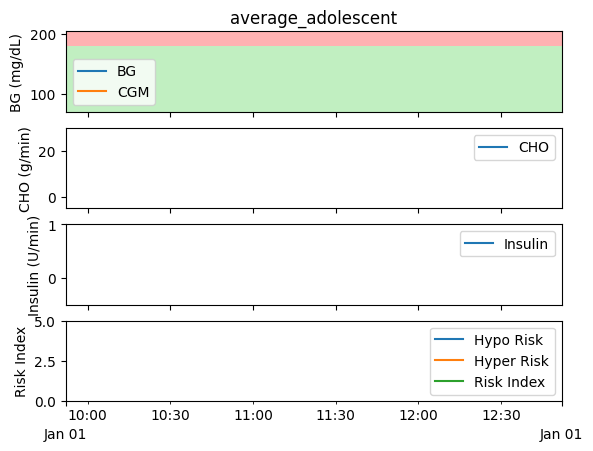

In [13]:
observation, info = env.reset()
for t in range(1000): # PAPER: While interval between meals < 5 hours
    env.render(mode='human')     
    print(observation)
    if observation[23] != 0:
        action = env.action_space.sample()
        print('Food was delicious!!!!!!!!!!!!!!!!!!!!!! MMMMMMMMMMhhhhhhhhhhhh...')
    else:
        action = [0, 0, 0]   
    observation, reward, done, _, info = env.step(action)     
    print('info  ', info)     
    if done:         
        print("Episode finished after {} timesteps".format(t + 1))         
        break

In [23]:
print(observation)

[79.035164  73.68302   68.58055   63.726593  59.117622  54.74371
 50.56326   46.490158  42.45433   39.51488   39.        39.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
 -3.9833224 -5.3297687 -6.93824   -8.895523  -5.4544973 -1.9494685
 -6.988207  -8.332682  -3.8538153 -3.1868508 -3.8307102 -5.370084 ]


In [26]:
env.reset()
action = env.action_space.sample()
env.step(action)

(array([ 1.3907034e+02,  1.3907034e+02,  1.3907034e+02,  1.3907034e+02,
         1.3907034e+02,  1.3907034e+02,  1.3907034e+02,  1.3907034e+02,
         1.3907034e+02,  1.3907034e+02,  1.3907034e+02,  1.3972990e+02,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -2.6918611e-02],
       dtype=float32),
 0.5,
 False,
 False,
 {'time': datetime.datetime(2018, 1, 1, 17, 3),
  'meal': 0,
  'patient_name': 'adolescent#001',
  'sample_time': 3.0})

In [11]:
print(env.observation_space.shape)
print(env.action_space.shape)
print(env.action_space.high)

(36,)
(3,)
[2. 2. 2.]


In [23]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

agent = DDPGAgent(env=env, device=device)
critic_loss = agent.train()

Iteration: 1, Critic loss: 97.812 (min: 97.812), Patience left: 100
Iteration: 6, Critic loss: 34.762 (min: 33.540), Patience left: 99
Iteration: 11, Critic loss: 8.809 (min: 8.809), Patience left: 100
Iteration: 16, Critic loss: 1.915 (min: 1.915), Patience left: 100
Iteration: 21, Critic loss: 1.293 (min: 1.293), Patience left: 100
Iteration: 26, Critic loss: 0.616 (min: 0.616), Patience left: 100
Iteration: 31, Critic loss: 1.122 (min: 0.596), Patience left: 98
Iteration: 36, Critic loss: 1.613 (min: 0.596), Patience left: 93
Iteration: 41, Critic loss: 1.660 (min: 0.596), Patience left: 88
Iteration: 46, Critic loss: 0.898 (min: 0.596), Patience left: 83
Iteration: 51, Critic loss: 1.003 (min: 0.596), Patience left: 78
Iteration: 56, Critic loss: 1.138 (min: 0.313), Patience left: 97
Iteration: 61, Critic loss: 1.497 (min: 0.313), Patience left: 92
Iteration: 66, Critic loss: 1.115 (min: 0.313), Patience left: 87
Iteration: 71, Critic loss: 0.817 (min: 0.313), Patience left: 82
Ite

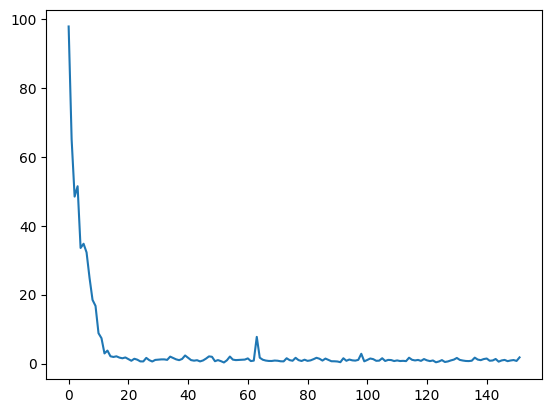

In [24]:
import matplotlib.pyplot as plt

plt.plot([x[0] for x in critic_loss])

info   {'time': datetime.datetime(2018, 1, 1, 5, 32), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 35), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 38), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 41), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 44), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 47), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 50), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': datetime.datetime(2018, 1, 1, 5, 53), 'meal': 0, 'patient_name': 'average_adolescent', 'sample_time': 3.0}
info   {'time': 

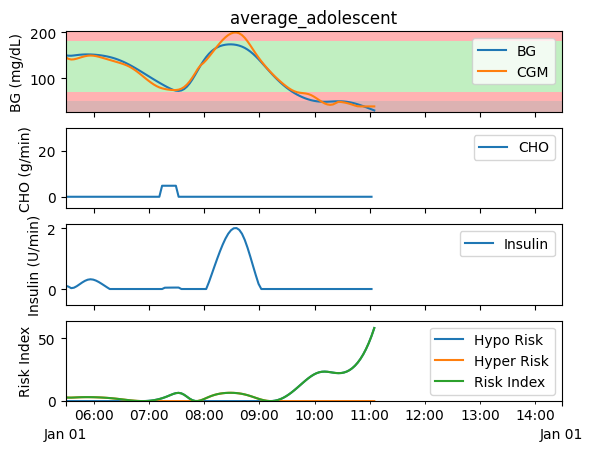

In [25]:
observation, info = env.reset()
for t in range(1000): # PAPER: While interval between meals < 5 hours
    env.render(mode='human')   
    action = agent.select_action(observation)
    observation, reward, done, _, info = env.step(action)     
    print('info  ', info)     
    if done:         
        print("Episode finished after {} timesteps".format(t + 1))         
        break